In [0]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings

Index(['dateTime', 'data'], dtype='object')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


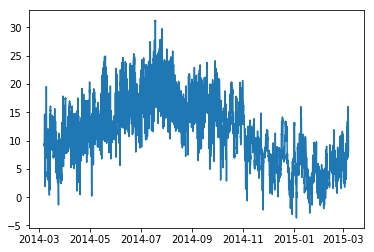

In [4]:
# import temperature time series
df = pd.read_csv('full_external_temperatures.csv', usecols=['dateTime', 'data'])
display(df.columns)
# convert to datetime object
df['dateTime'] = pd.to_datetime(df['dateTime'])
# # convert to pandas time series
ts = df.set_index('dateTime')
# plot results
plt.plot(ts)

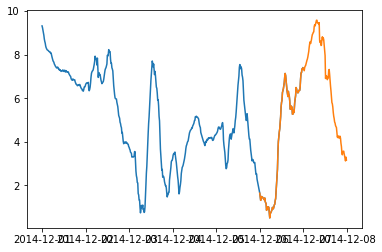

In [7]:
# let's take a slice of our data, e.g., 3 weeks
ts = ts.loc['2014-12-01':'2014-12-07']
ts_train = ts.loc['2014-12-01':'2014-12-06']
ts_test = ts.loc['2014-12-06':'2014-12-07']
# plot
plt.plot(ts_train)
plt.plot(ts_test)

In [0]:
# let's check the order of parameter d
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values)
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
 


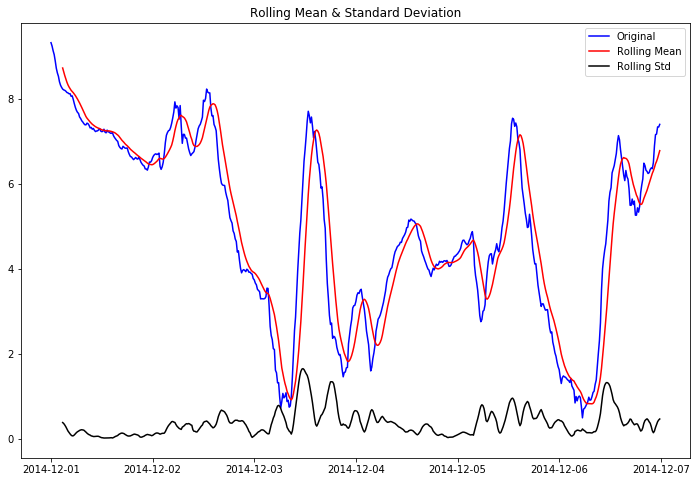

Results of Dickey-Fuller Test:
p-value = 0.0112. The series is likely non-stationary.


0

In [9]:
test_stationarity(ts_train)
ndiffs(ts_train, test='adf')  # ad-fuller test

In [0]:
# if time series is stationary, parameter d = 0
d = 1

In [0]:
# evaluate an ARIMA model for a given order (p,d,q)
def check_arima_model(ts, arima_order):
    # prepare training dataset
    train_size = int(len(ts) * 0.6)
    train, test = ts[0:train_size], ts[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    #for t in range(len(test)):
    #    model = ARIMA(history, order=arima_order)
    #    model_fit = model.fit(disp=0)
    #    yhat = model_fit.forecast()[0]
    #    predictions.append(yhat)
    #    history.append(test[t])
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhats = model_fit.forecast(len(test))[0]
    predictions = [x for x in yhats]
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [0]:
# evaluate combinations of p and q values for an ARIMA model
def get_arima_order(ts, p_vector, q_vector, d=0):
    best_score, best_cfg = float("inf"), None
    for p in p_vector:
        for q in q_vector:
            order = (p, d, q)
            try:
                mse = check_arima_model(ts, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
            except:
                continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


In [13]:
# let's generate the ranges of values
p_vector = range(0, 3)
q_vector = range(0, 3)
warnings.filterwarnings("ignore")
get_arima_order(ts_train.iloc[:,0].values, p_vector, q_vector, d=0)

ARIMA(0, 0, 0) MSE=4.745
Best ARIMA(0, 0, 0) MSE=4.745


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  576
Model:                     ARMA(2, 1)   Log Likelihood                 337.402
Method:                       css-mle   S.D. of innovations              0.134
Date:                Sun, 13 Oct 2019   AIC                           -664.804
Time:                        09:42:15   BIC                           -643.024
Sample:                             0   HQIC                          -656.310
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2391      0.654      8.010      0.000       3.957       6.521
ar.L1.y        1.8840      0.027     69.702      0.000       1.831       1.937
ar.L2.y       -0.8883      0.027    -32.874      0.0

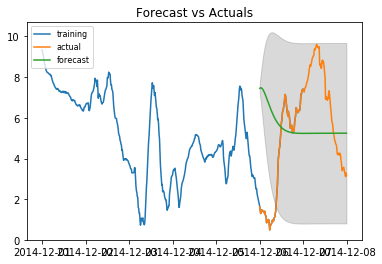

In [14]:
# Build Model
model = ARIMA(ts_train.iloc[:,0].values, order=(2, 0, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(ts_test), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=ts_test.index)
lower_series = pd.Series(conf[:, 0], index=ts_test.index)
upper_series = pd.Series(conf[:, 1], index=ts_test.index)

# Plot
plt.figure()
plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
# auto arima
import pmdarima as pm
model = pm.auto_arima(ts_train.iloc[:,0].values, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, m=1,d=None, 
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())
n_periods = len(ts_test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = ts_test.index
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=ts_test.index)
upper_series = pd.Series(confint[:, 1], index=ts_test.index)

Fit ARIMA: order=(1, 0, 1); AIC=-521.303, BIC=-503.878, Fit time=0.198 seconds
Fit ARIMA: order=(0, 0, 0); AIC=2516.533, BIC=2525.245, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-331.999, BIC=-318.931, Fit time=0.056 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1761.949, BIC=1775.017, Fit time=0.039 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-664.804, BIC=-643.024, Fit time=0.376 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-619.191, BIC=-601.767, Fit time=0.113 seconds
Fit ARIMA: order=(2, 0, 2); AIC=-664.706, BIC=-638.570, Fit time=0.593 seconds
Fit ARIMA: order=(3, 0, 2); AIC=-668.766, BIC=-638.273, Fit time=0.449 seconds
Fit ARIMA: order=(4, 0, 2); AIC=-671.631, BIC=-636.782, Fit time=0.555 seconds
Fit ARIMA: order=(4, 0, 1); AIC=-673.265, BIC=-642.773, Fit time=0.411 seconds
Fit ARIMA: order=(3, 0, 0); AIC=-643.085, BIC=-621.305, Fit time=0.160 seconds
Fit ARIMA: order=(5, 0, 2); AIC=-670.057, BIC=-630.852, Fit time=0.788 seconds
Fit ARIMA: order=(3, 0, 1); AIC=-663.943, BIC=-637.8

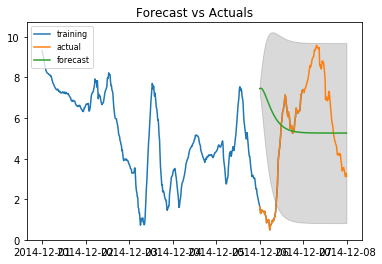

In [16]:
# Plot auto arima results
plt.figure()
plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
# seasonality
model = pm.auto_arima(ts_train.iloc[:,0].values, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, m=1,d=None, 
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())
n_periods = len(ts_test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = ts_test.index
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=ts_test.index)
upper_series = pd.Series(confint[:, 1], index=ts_test.index)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-521.199, BIC=-503.775, Fit time=0.257 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2516.533, BIC=2525.245, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-331.999, BIC=-318.931, Fit time=0.210 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1761.949, BIC=1775.017, Fit time=0.200 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-664.804, BIC=-643.024, Fit time=0.914 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-619.191, BIC=-601.766, Fit time=0.462 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-664.706, BIC=-638.570, Fit time=1.220 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-668.766, BIC=-638.273, Fit time=1.422 seconds
Fit ARIMA: order=(4, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-671.539, BIC=-636.690, Fit time=1.478 seconds
Fit ARIMA: order=(4, 0, 1) seasonal_o

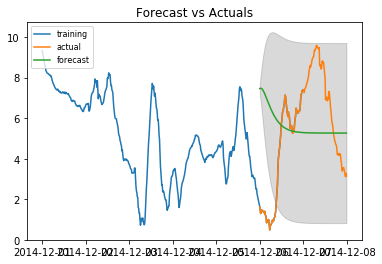

In [18]:
# Plot auto sarima results
plt.figure()
plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **My Test and fit :**

In [0]:
# Build Model
model_arima = ARIMA(ts_train.iloc[:,0].values, order=(2, 0, 1))  
fitted = model_arima.fit(disp=-1)  


In [49]:
print(type(ts_test))

<class 'pandas.core.frame.DataFrame'>


In [50]:
print(len(ts_test))

192


In [0]:
result, se, conf = fitted.forecast(len(ts_test),alpha=0.05)

In [65]:
print(result, "  ",se,"  ", conf)

[7.43451245 7.45562749 7.46474939 7.46317772 7.45211344 7.43266466
 7.40585219 7.37261486 7.33381462 7.29024132 7.24261738 7.19160213
 7.13779605 7.08174468 7.02394241 6.96483602 6.90482809 6.84428014
 6.78351569 6.72282306 6.66245807 6.60264654 6.54358669 6.4854513
 6.42838987 6.37253052 6.31798185 6.26483462 6.21316338 6.16302793
 6.11447472 6.06753812 6.02224165 5.97859908 5.93661543 5.89628796
 5.85760705 5.82055697 5.78511668 5.75126048 5.71895865 5.68817805
 5.6588826  5.63103381 5.60459121 5.57951271 5.55575501 5.5332739
 5.51202455 5.49196179 5.47304032 5.45521497 5.43844081 5.42267339
 5.40786882 5.39398394 5.38097642 5.36880482 5.35742872 5.34680873
 5.33690659 5.32768519 5.31910859 5.31114207 5.30375215 5.29690655
 5.29057425 5.28472547 5.27933163 5.27436539 5.26980057 5.2656122
 5.26177645 5.25827062 5.2550731  5.25216337 5.24952194 5.24713033
 5.24497105 5.24302753 5.24128413 5.23972609 5.23833947 5.23711116
 5.23602883 5.23508088 5.23425642 5.23354525 5.23293781 5.2324251

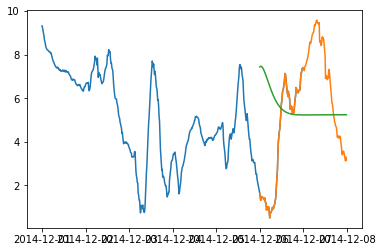

In [66]:
fc_series = pd.Series(result,index=ts_test.index)

plt.figure()
plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()

In [0]:
# Build Model
model_arima = ARIMA(ts_train.iloc[:,0].values, order=(2, 0, 1))  
fitted = model_arima.fit(disp=0)  


In [0]:
result2 = fitted.forecast(len(ts_test))

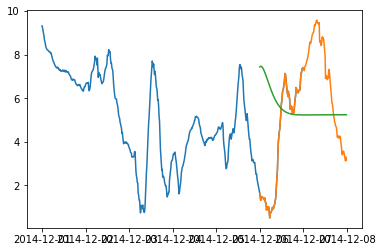

In [70]:
fc_series = pd.Series(result2[0],index=ts_test.index)
plt.figure()
plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()